In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import time
pd.set_option('mode.chained_assignment', None)

In [2]:
# Function to create lagged features
def create_lagged_features(data, lag=1):
    for i in range(1, lag+1):
        data[f'humi_lag_{i}'] = data['humi'].shift(i)
    return data

# function for converting '-' values to numbers
# col_k : 'k_temp' or col_k : 'k_rain'
def col_k_dash_remover(df, col_k):
    if len(df) != 0:
        cnt = 0
        for i in range(len(df)):
            # Num_rows : 1
            if len(df) == 1 and '-' in df[col_k].iloc[i]:
                df[col_k].iloc[i] = 0
            # Num_rows : 2
            if len(df) == 2 and i == 0:
                if '-' in df[col_k].iloc[i] and '-' not in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = df[col_k].iloc[i+1]
                elif '-' not in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:    
                    df[col_k].iloc[i+1] = df[col_k].iloc[i]
                elif '-' in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = 0
                    df[col_k].iloc[i+1] = 0
            # ----------------------------------------------------------------------------------
            # Num_rows > 2
            if len(df) > 2:
                ## initial term
                if i == 0 and '-' in df[col_k].iloc[i]: 
                    # CASE1 : '-' // num
                    if '-' not in df[col_k].iloc[i+1]:
                        #print('CASE1-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i+1]
                    # CASE2 : '-' // '-'
                    elif '-' in df[col_k].iloc[i+1]:
                        #df[col_k].iloc[i] = 0
                        #print('CASE1-2')
                        cnt += 1
                        continue
                ## middle term ---------------------------------------------------------------------------
                elif i > 0 and '-' in df[col_k].iloc[i] and i < len(df) - 1:
                     # CASE1 : ordinary ; prev : num // current : '-' // next : num 
                    if '-' not in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        #print('CASE2-1')
                        df[col_k].iloc[i] = str((int(df[col_k].iloc[i-1]) + int(df[col_k].iloc[i+1]))//2)
                    # CASE2 : '-' // '-' // '-'
                    elif '-' in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #print('CASE2-2')
                        cnt += 1
                        continue
                    # CASE3 : num // '-' // '-'
                    elif '-' not in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #print('CASE2-3')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE4 : '-' // '-' // num
                    elif '-' in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        cnt += 1
                        # sum
                        #print('CASE2-4')
                        for j in range(cnt):
                            #print('i : {}'.format(i))
                            #print('j : {}'.format(j))
                            #print('cnt : {}'.format(cnt))
                            #print('i - cnt + j : {}'.format(i-cnt+j+1))
                            df[col_k].iloc[i-cnt+j+1] = df[col_k].iloc[i+1]
                            #print(df[col_k].iloc[i+1])
                            #print('-'*10)
                            #print(df[col_k].iloc[i-cnt+j+1])
                            #print('-'*20)
                        # -------
                        cnt = 0
                # -------------------------------------------------------------------------------------------
                ## final term
                elif i == len(df) - 1 and '-' in df[col_k].iloc[i]:
                    # CASE1 : num // '-'
                    if '-' not in df[col_k].iloc[i-1]:
                        #print('CASE3-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE2 : '-' // '-' # ex. in the case all data values : '-'
                    elif '-' in df[col_k].iloc[i-1]:
                        #print('CASE3-2')
                        # sum
                        if cnt == len(df) - 1:
                            for j in range(cnt):
                                df[col_k].iloc[j] = 0
                        else:
                            print('CASE3-4')
                            print('case inspection needed ...')
# =============================================================================================================
def ts_df_maker(df,year,month,period):
    if period > 1: # add extra conditions later
        for i in range(period):
            if len(str(month)) == 1:
                ym = str(year) + '-0' + str(month)
                print('Period > 1')
                print(ym)
            elif len(str(month)) == 2:
                ym = str(year) + '-' + str(month)
                print('Period > 1')
                print(ym)
            # ------------------------------------------------
            if i == 0:
                df_ = df[df['sensingTime'].str.contains(ym)]
            else:
                df0 = df_
                df_ = pd.concat([df0, df[df['sensingTime'].str.contains(ym)]], axis = 0)
            month += 1
    elif period == 1:
        if len(str(month)) == 1:
            ym = str(year) + '-0' + str(month)
            print('Period : 1')
            print(ym)
        elif len(str(month)) == 2:
            ym = str(year) + '-' + str(month)
        df_ = df[df['sensingTime'].str.contains(ym)]
    else:
        print('Reset the period.')
        df_ = df    
            
    return df_

### ==============================================================================================================
### ==============================================================================================================

def build_model(X_train):
    from tensorflow.keras.models import Sequential
    
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))  # Output layer with 1 neuron for predicting humidity

    # Compile the model
    model.compile(optimizer='adam', loss='mse')  # Mean Squared Error is used as the loss function
    
    return model

def fit_model(model,X_train,y_train):
    # Train the model
    #model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
def scale_data(df_input):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    df_input_scaled = scaler.fit_transform(df_input)
    df_input_scaled_ = df_input_scaled.reshape((df_input_scaled.shape[0],1,df_input_scaled.shape[1]))
    # -----------------------------------------------------------------------------------------------
    
    return df_input_scaled_

def scale_data_target(df_input):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    df_input_scaled = scaler.fit_transform(df_input)
    df_input_scaled_ = df_input_scaled.reshape((df_input_scaled.shape[0],1,df_input_scaled.shape[1]))
    # -----------------------------------------------------------------------------------------------
    
    return df_input_scaled_,scaler


def predict_data(model, X_sep):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    #scaler = MinMaxScaler()
    # Predict on the reshaped data
    y_sep_predicted = model.predict(X_sep)
    # ------------------------------------------------------------------------------------
    # Reshape the predicted values to (n_samples, 1)
    y_sep_predicted_reshaped = y_sep_predicted.reshape((y_sep_predicted.shape[0], 1))
    # Inverse transform the reshaped predicted values to the original scale
    y_sep_pred = scaler.inverse_transform(
        np.hstack([y_sep_predicted_reshaped, np.zeros((y_sep_predicted_reshaped.shape[0], X_sep.shape[1] - 1))])
    )
    return y_sep_pred


def predict_data_target(model, X_sep, scaler):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    #scaler = MinMaxScaler()
    # Predict on the reshaped data
    y_sep_predicted = model.predict(X_sep)
    # ------------------------------------------------------------------------------------
    # Reshape the predicted values to (n_samples, 1)
    y_sep_predicted_reshaped = y_sep_predicted.reshape((y_sep_predicted.shape[0], 1))
    # Inverse transform the reshaped predicted values to the original scale
    y_sep_pred = scaler.inverse_transform(
        np.hstack([y_sep_predicted_reshaped, np.zeros((y_sep_predicted_reshaped.shape[0], X_sep.shape[2] - 1))])
    )
    return y_sep_pred

def model_eval(model,X_test,y_test):
    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Mean Squared Error on Test Data: {loss}')
    
def save_ypred_df(y_sep_pred):
    # Extract the first column to get the desired shape (193, 1)
    y_sep_pred_column = y_sep_pred[:, 0].reshape(-1, 1)
    y_sep_pred_df = pd.DataFrame(y_sep_pred_column)
    return y_sep_pred_df

def process_model(X_build,X_fit,y_fit,X_target,scaler):
    # build model
    model = build_model(X_build)
    # fit model
    fit_model(model,X_fit,y_fit)
    ##model_eval(model,X_target,y_target) # optional
    #y_pred = predict_data(model, X_target, scaler)
    y_pred = predict_data_target(model, X_target, scaler)
    df_y_pred = save_ypred_df(y_pred)
    return df_y_pred



the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11


Epoch 1/50

6/6 [==============================] - 1s 2ms/step - loss: 0.1525
Epoch 2/50
6/6 [==============================] - 0s 800us/step - loss: 0.0760
Epoch 3/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0454
Epoch 4/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0440
Epoch 5/50
6/6 [==============================] - 0s 800us/step - loss: 0.0426
Epoch 6/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0367
Epoch 7/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 8/50
6/6 [==============================] - 0s 800us/step - loss: 0.0280
Epoch 9/50
6/6 [==============================] - 0s 800us/step - loss: 0.0255
Epoch 10/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 11/50
6/6 [==============================] 

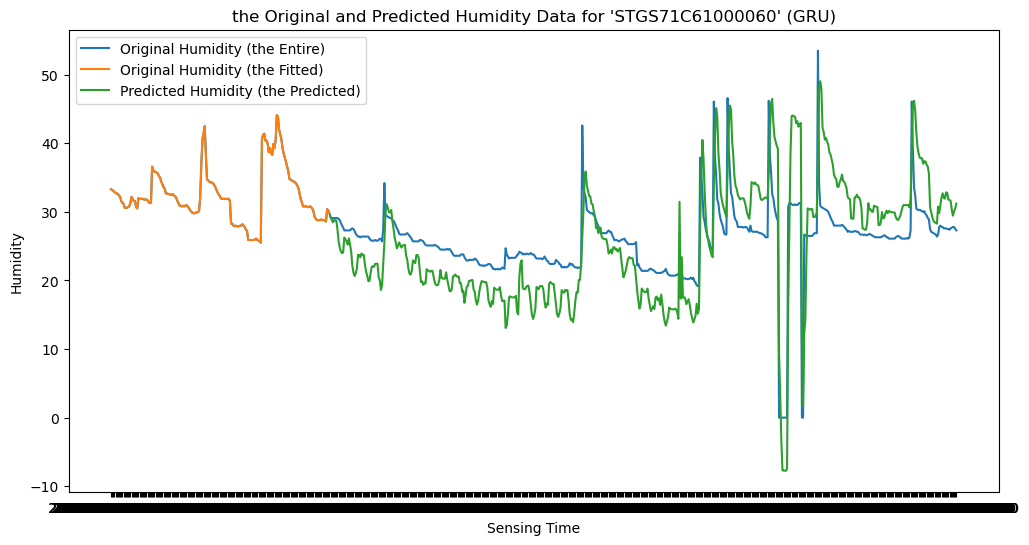

In [12]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000060'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0912
Epoch 2/50
7/7 [==============================] - 0s 834us/step - loss: 0.0496
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0344
Epoch 4/50
7/7 [==============================] - 0s 833us/step - loss: 0.0292
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0236
Epoch 6/50
7/7 [==============================] - 0s 834us/step - loss: 0.0187
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0113
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss

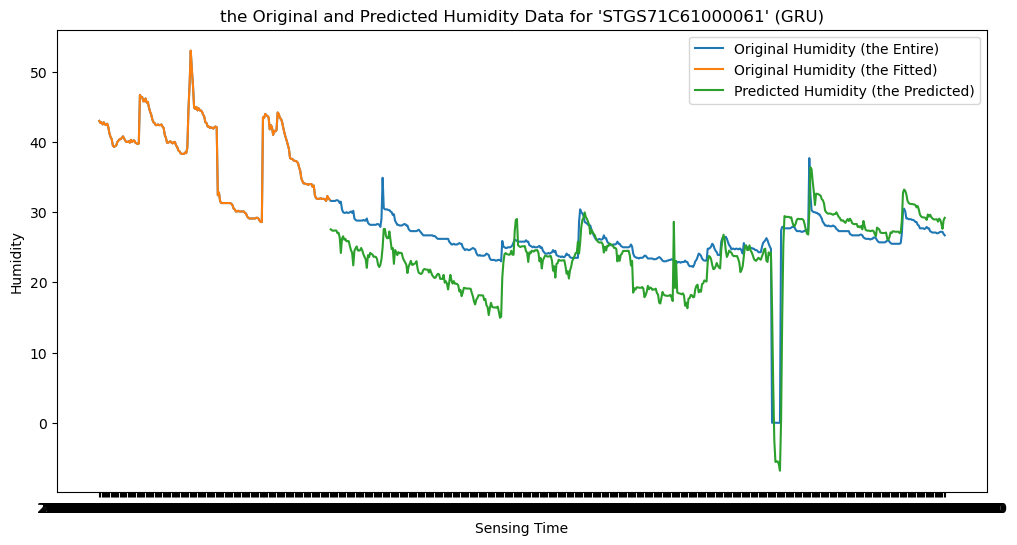

In [4]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000061'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0976
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0550
Epoch 3/50
7/7 [==============================] - 0s 834us/step - loss: 0.0336
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0267
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0198
Epoch 8/50
7/7 [==============================] - 0s 833us/step - loss: 0.0179
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 10/50
7/7 [==============================] - 0s 833us/step - loss: 0.0143
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss

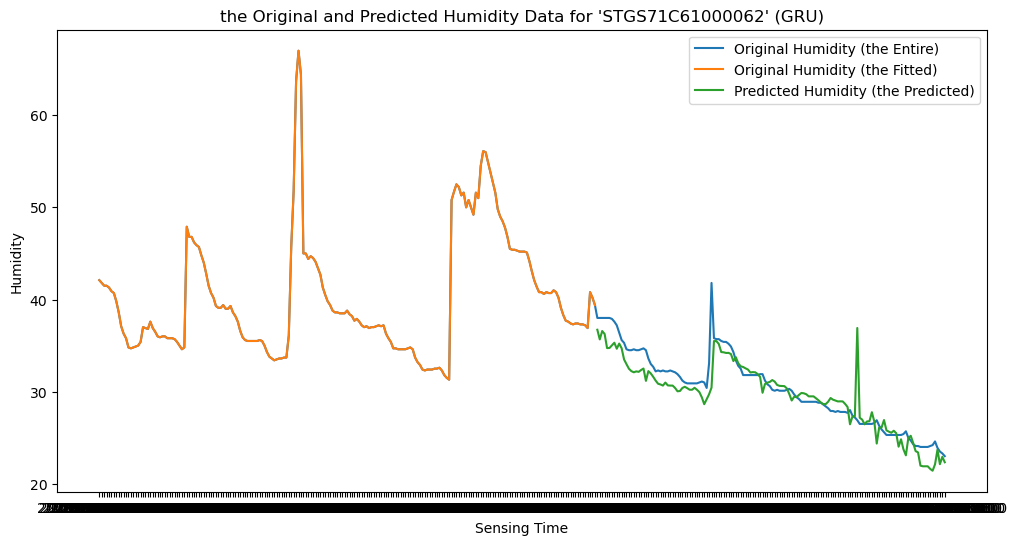

In [5]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000062'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1021
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0447
Epoch 4/50
7/7 [==============================] - 0s 834us/step - loss: 0.0340
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0315
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0281
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0188
Epoch 10/50
7/7 [==============================] - 0s 845us/step - loss: 0.0164
Epoch 11/50
7/7 [==============================] - 0s 834us/step - loss

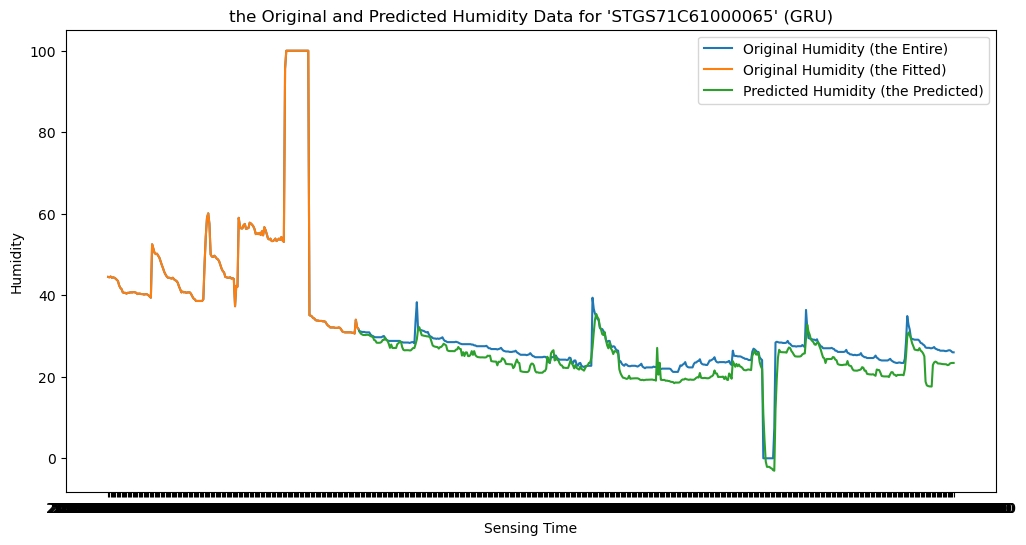

In [6]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000065'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0197
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0170
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 4/50
7/7 [==============================] - 0s 833us/step - loss: 0.0142
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0131
Epoch 6/50
7/7 [==============================] - 0s 833us/step - loss: 0.0123
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 8/50
7/7 [==============================] - 0s 834us/step - loss: 0.0110
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0102
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss

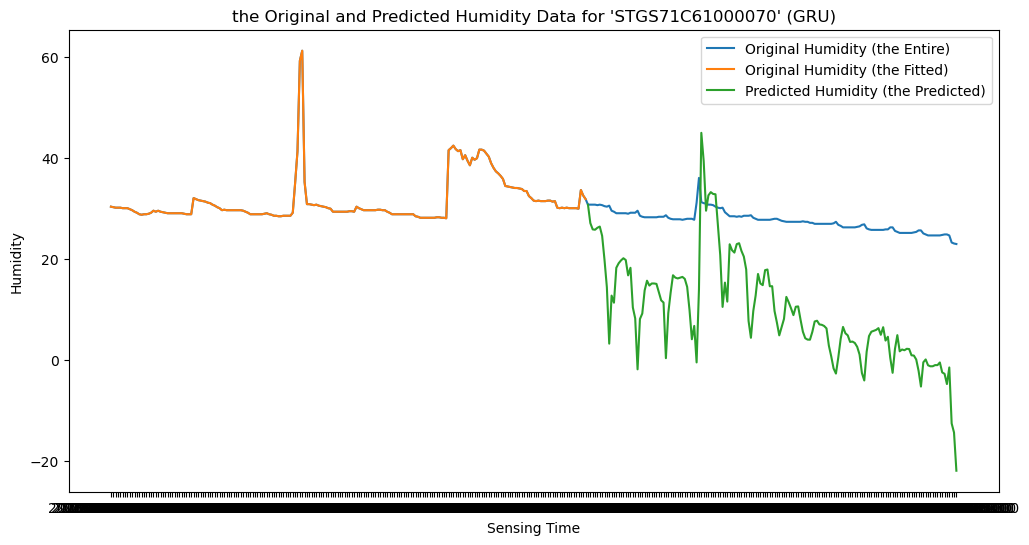

In [7]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000070'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.2914
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1481
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0351
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0274
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0280
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0263
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 9/50
7/7 [==============================] - 0s 833us/step - loss: 0.0218
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0206
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.

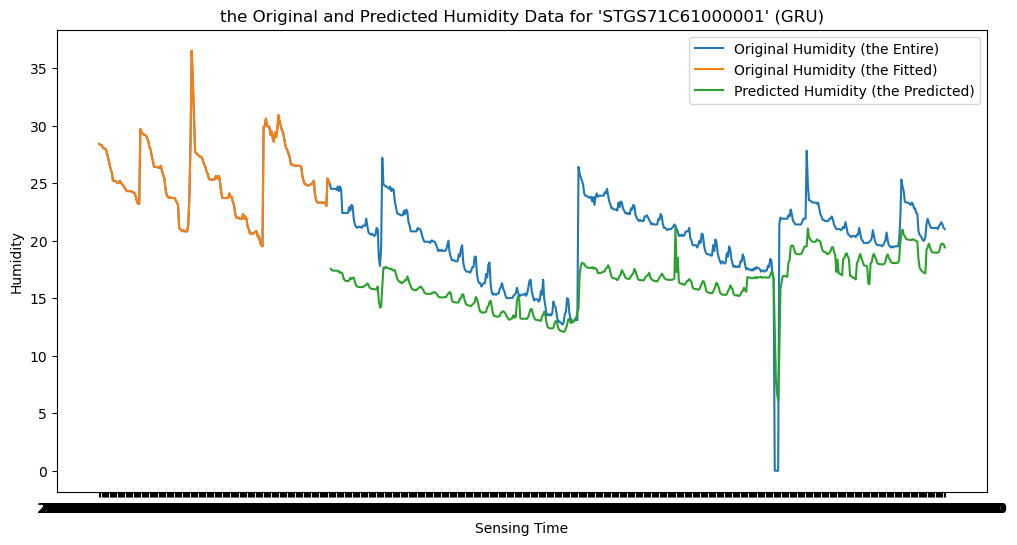

In [8]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000001'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
6/6 [==============================] - 1s 1ms/step - loss: 0.0652
Epoch 2/50
6/6 [==============================] - 0s 800us/step - loss: 0.0450
Epoch 3/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0395
Epoch 4/50
6/6 [==============================] - 0s 800us/step - loss: 0.0361
Epoch 5/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0322
Epoch 6/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0284
Epoch 7/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0252
Epoch 8/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 9/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 10/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0188
Epoch 11/50
6/6 [==============================] - 0s 800us/step - loss: 0.

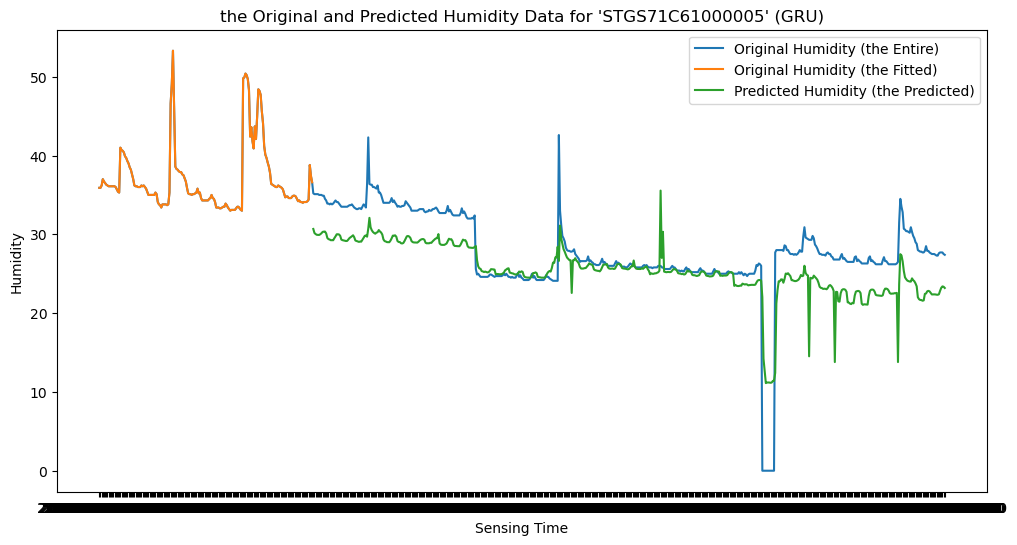

In [9]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000005'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1460
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0868
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 4/50
7/7 [==============================] - 0s 833us/step - loss: 0.0448
Epoch 5/50
7/7 [==============================] - 0s 833us/step - loss: 0.0388
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 7/50
7/7 [==============================] - 0s 833us/step - loss: 0.0268
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0170
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.

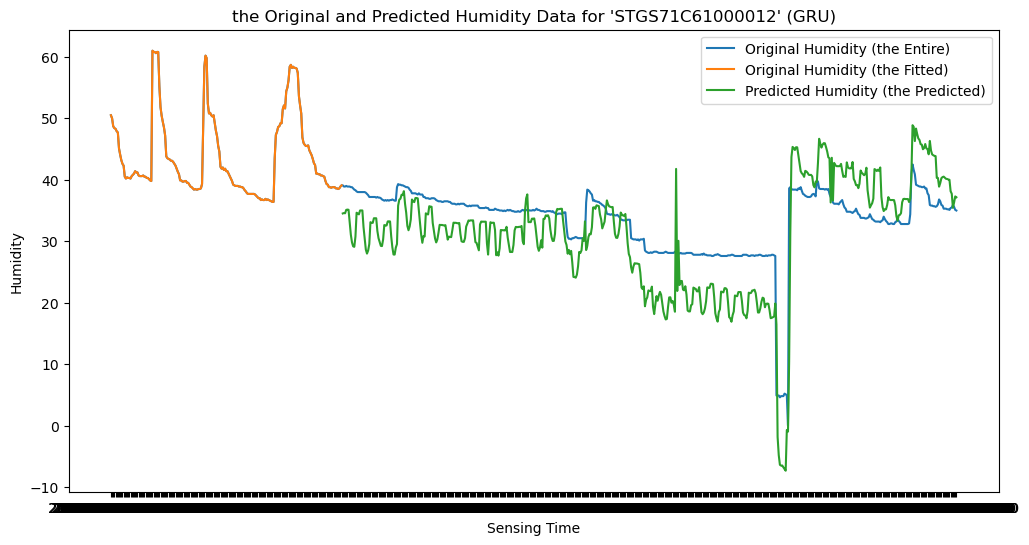

In [10]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000012'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0615
Epoch 2/50
7/7 [==============================] - 0s 833us/step - loss: 0.0303
Epoch 3/50
7/7 [==============================] - 0s 834us/step - loss: 0.0171
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 6/50
7/7 [==============================] - 0s 840us/step - loss: 0.0123
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0109
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 9/50
7/7 [==============================] - 0s 841us/step - loss: 0.0093
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0085
Epoch 11/50
7/7 [==============================] - 0s 834us/step - 

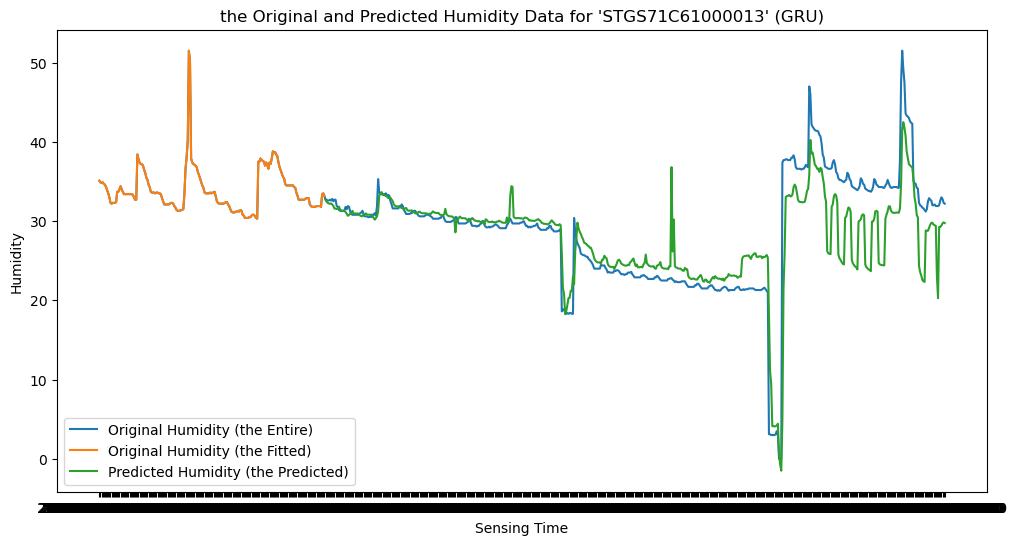

In [11]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000013'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0697
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0332
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0251
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 8/50
7/7 [==============================] - 0s 833us/step - loss: 0.0169
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0149
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.

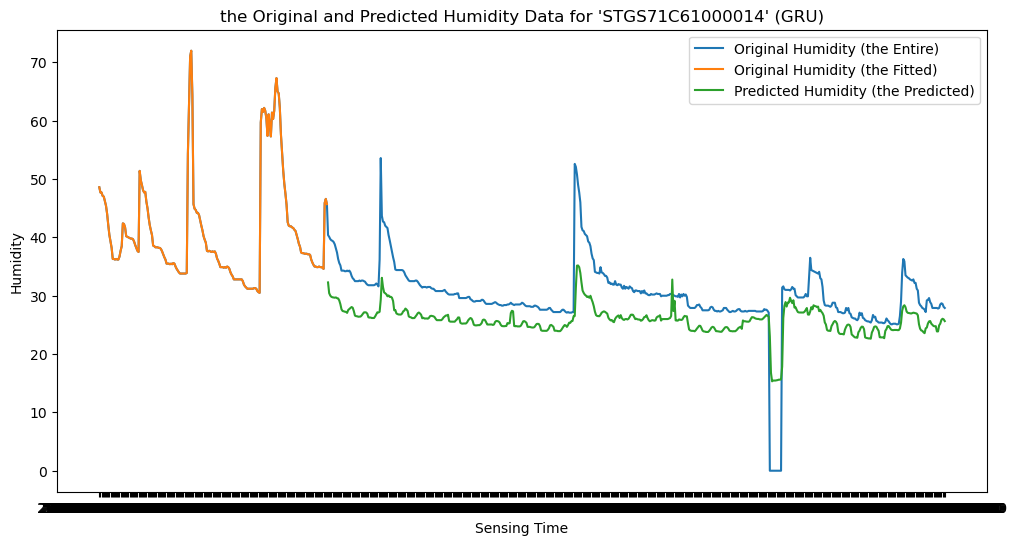

In [12]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000014'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.2230
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1157
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0530
Epoch 4/50
7/7 [==============================] - 0s 834us/step - loss: 0.0259
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0231
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 8/50
7/7 [==============================] - 0s 833us/step - loss: 0.0135
Epoch 9/50
7/7 [==============================] - 0s 833us/step - loss: 0.0122
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 11/50
7/7 [==============================] - 0s 1000us/step - los

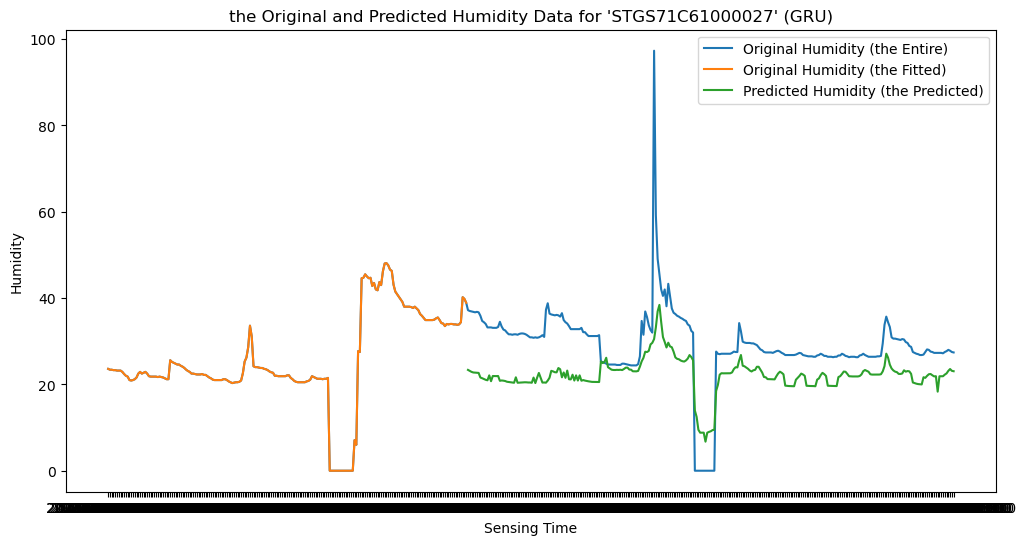

In [13]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000027'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0115
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 3/50
7/7 [==============================] - 0s 834us/step - loss: 0.0080
Epoch 4/50
7/7 [==============================] - 0s 834us/step - loss: 0.0070
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 6/50
7/7 [==============================] - 0s 834us/step - loss: 0.0063
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0058
Epoch 8/50
7/7 [==============================] - 0s 834us/step - loss: 0.0058
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0054
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0052
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - 

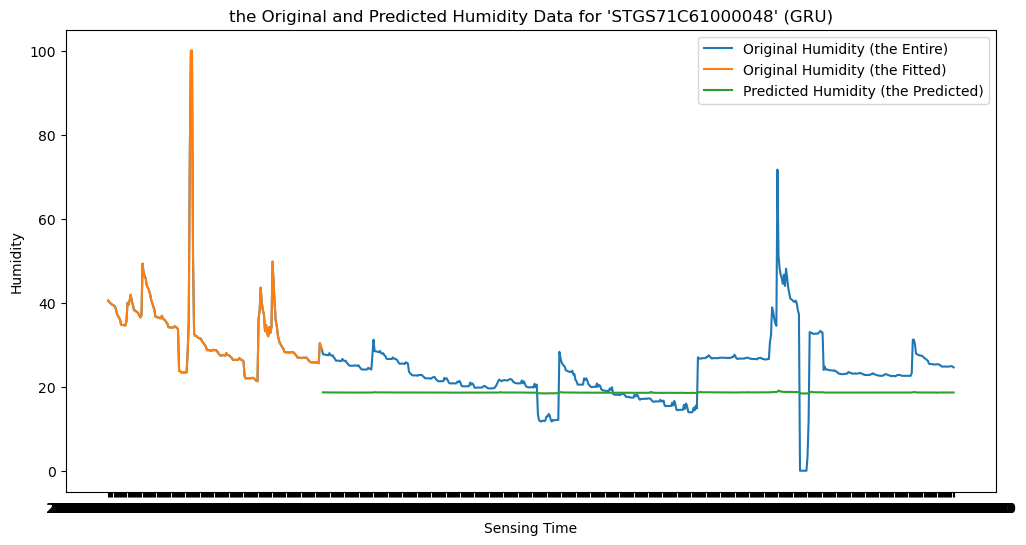

In [14]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000048'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1040
Epoch 2/50
7/7 [==============================] - 0s 833us/step - loss: 0.0507
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 5/50
7/7 [==============================] - 0s 833us/step - loss: 0.0259
Epoch 6/50
7/7 [==============================] - 0s 833us/step - loss: 0.0214
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0181
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0127
Epoch 11/50
7/7 [==============================] - 0s 840us/step - loss

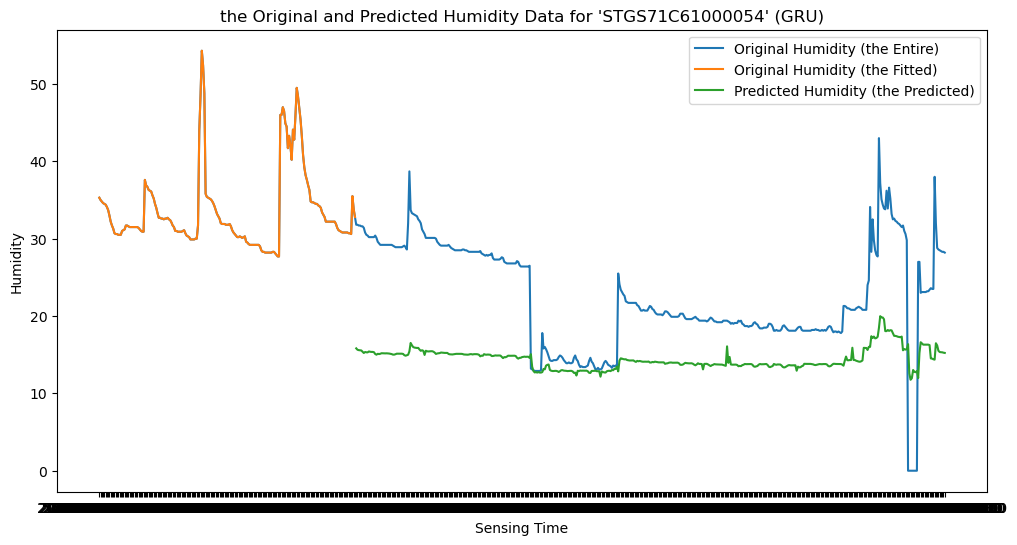

In [15]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000054'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.2934
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1822
Epoch 3/50
7/7 [==============================] - 0s 834us/step - loss: 0.0977
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0348
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0329
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0231
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0177

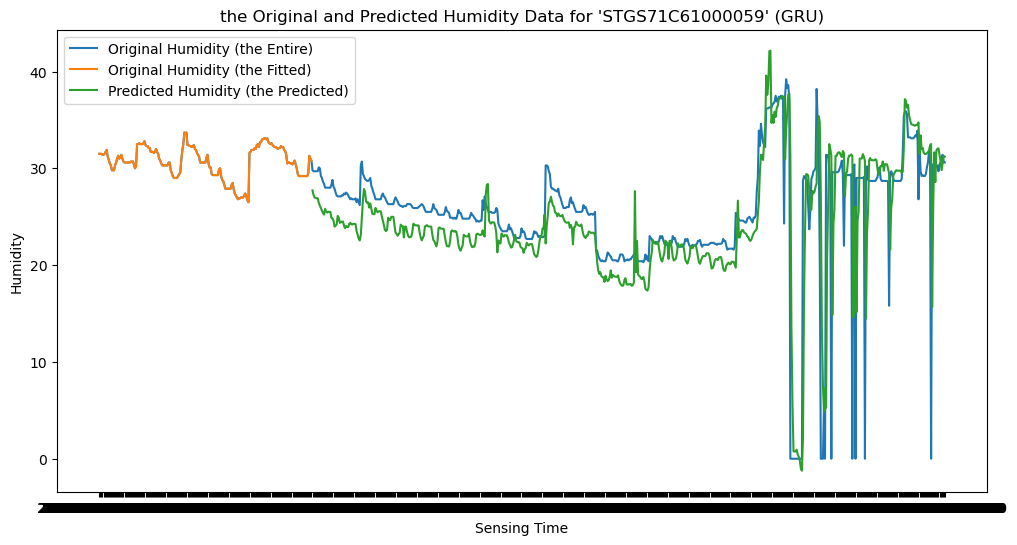

In [16]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000059'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1459
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0799
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0416
Epoch 4/50
7/7 [==============================] - 0s 834us/step - loss: 0.0324
Epoch 5/50
7/7 [==============================] - 0s 833us/step - loss: 0.0304
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0273
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0229
Epoch 8/50
7/7 [==============================] - 0s 834us/step - loss: 0.0195
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0172
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss

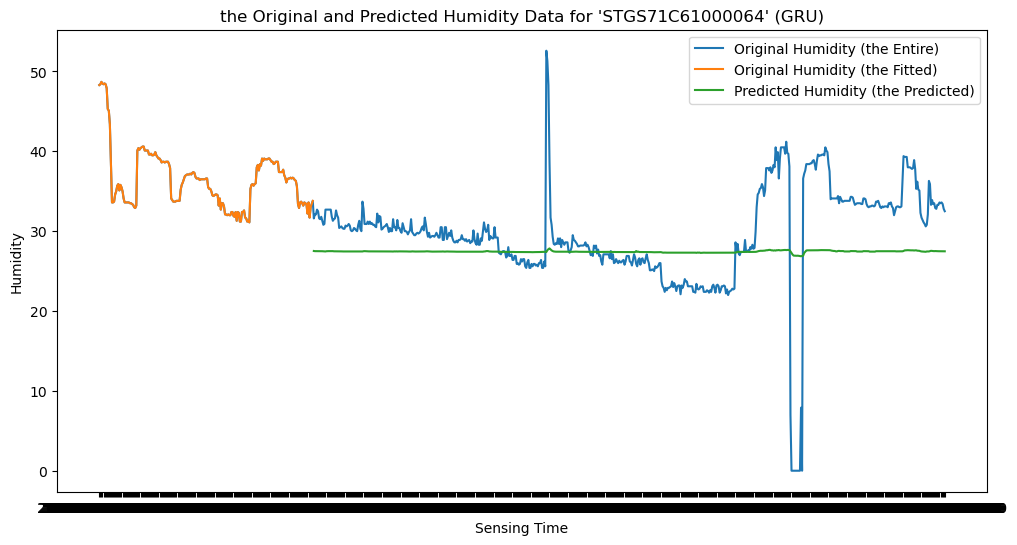

In [17]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000064'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1562
Epoch 2/50
7/7 [==============================] - 0s 834us/step - loss: 0.0933
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0597
Epoch 4/50
7/7 [==============================] - 0s 833us/step - loss: 0.0478
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0438
Epoch 6/50
7/7 [==============================] - 0s 834us/step - loss: 0.0389
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0339
Epoch 8/50
7/7 [==============================] - 0s 834us/step - loss: 0.0301
Epoch 9/50
7/7 [==============================] - 0s 833us/step - loss: 0.0269
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 11/50
7/7 [==============================] - 0s 834us/step - 

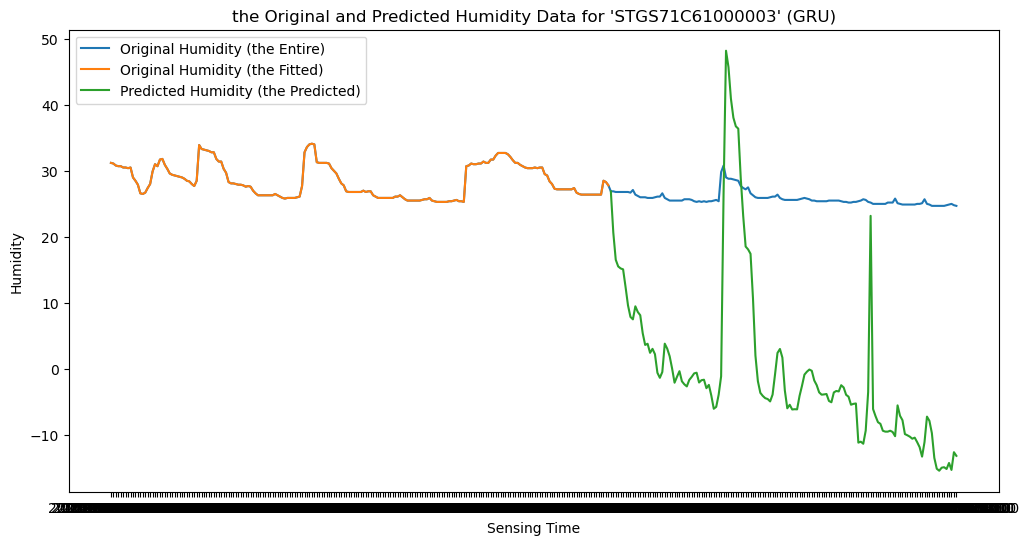

In [18]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000003'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
5/5 [==============================] - 1s 1ms/step - loss: 0.2363
Epoch 2/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 3/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0970
Epoch 4/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0597
Epoch 5/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0428
Epoch 6/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0404
Epoch 7/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 8/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 9/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 10/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 11/50
5/5 [==============================] - 0s 1ms/step - loss: 0.0250
E

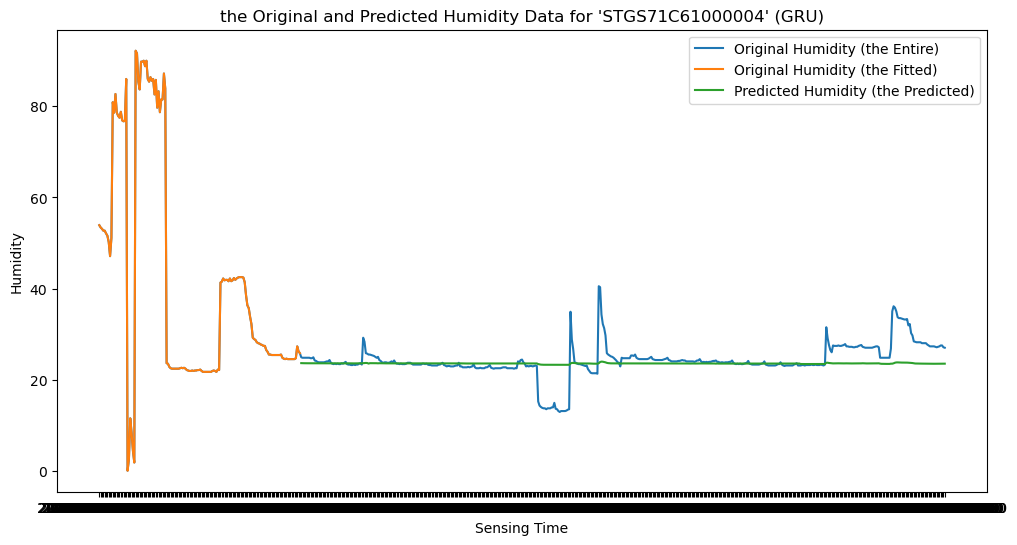

In [19]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000004'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1855
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1031
Epoch 3/50
7/7 [==============================] - 0s 833us/step - loss: 0.0604
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0270
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0211
Epoch 8/50
7/7 [==============================] - 0s 834us/step - loss: 0.0185
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 11/50
7/7 [==============================] - 0s 834us/step - loss: 

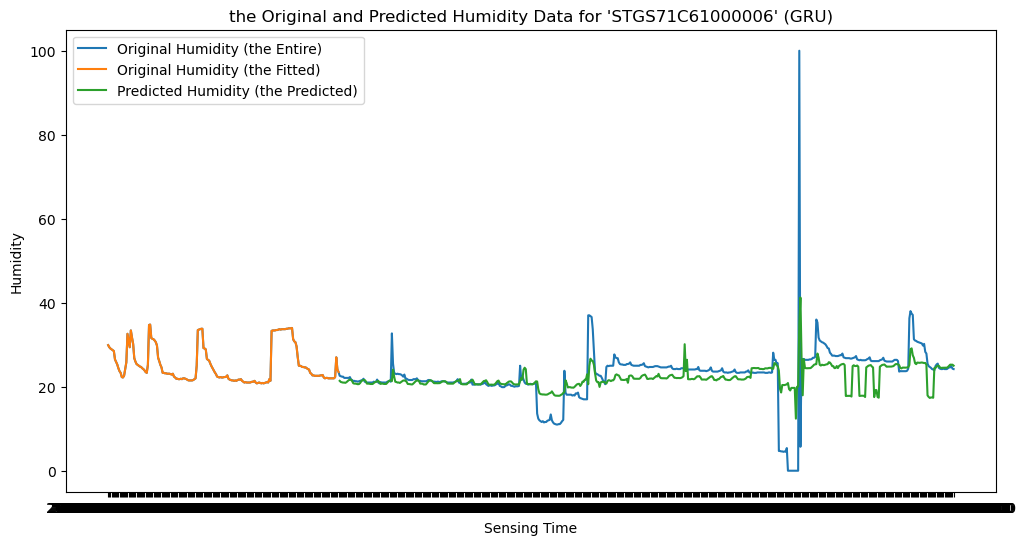

In [20]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000006'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
6/6 [==============================] - 1s 1ms/step - loss: 0.1072
Epoch 2/50
6/6 [==============================] - 0s 800us/step - loss: 0.0708
Epoch 3/50
6/6 [==============================] - 0s 800us/step - loss: 0.0588
Epoch 4/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0483
Epoch 5/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0439
Epoch 6/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 7/50
6/6 [==============================] - 0s 800us/step - loss: 0.0322
Epoch 8/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 9/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 10/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 11/50
6/6 [==============================] - 0s 800us/step - loss: 

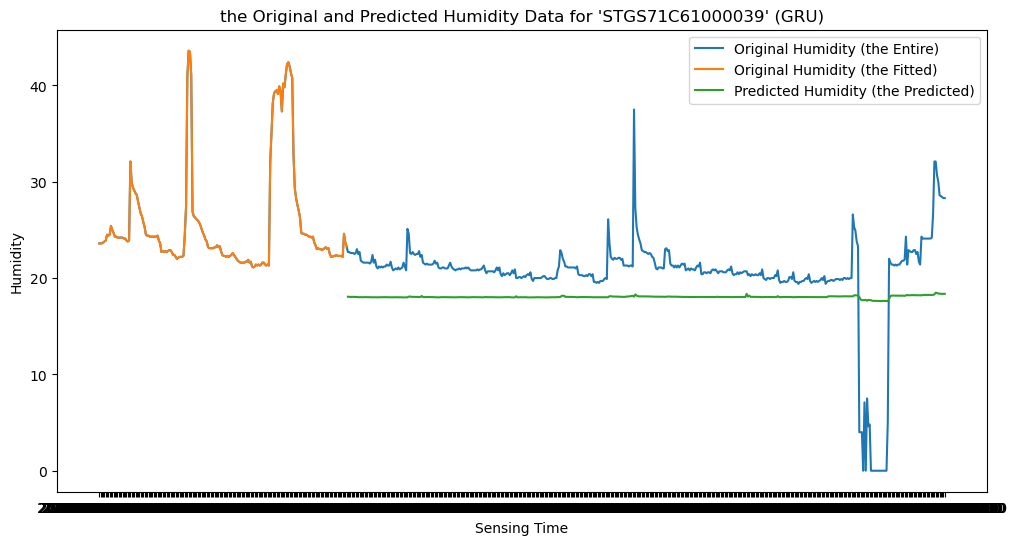

In [21]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000039'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1941
Epoch 2/50
7/7 [==============================] - 0s 834us/step - loss: 0.1418
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1054
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0785
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0600
Epoch 6/50
7/7 [==============================] - 0s 834us/step - loss: 0.0510
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0467
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0421
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0372
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 11/50
7/7 [==============================] - 0s 834us/step - loss: 

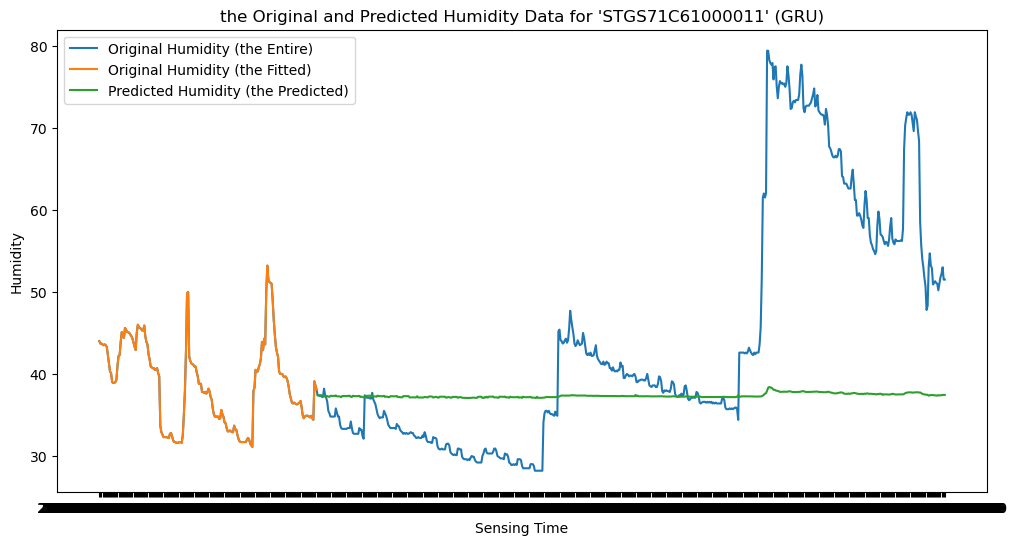

In [22]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000011'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.4777
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.3326
Epoch 3/50
7/7 [==============================] - 0s 833us/step - loss: 0.2255
Epoch 4/50
7/7 [==============================] - 0s 834us/step - loss: 0.1410
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0829
Epoch 6/50
7/7 [==============================] - 0s 834us/step - loss: 0.0492
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0391
Epoch 8/50
7/7 [==============================] - 0s 834us/step - loss: 0.0375
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0345
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0306
Epoch 11/50
7/7 [==============================] - 0s 834us/step - loss

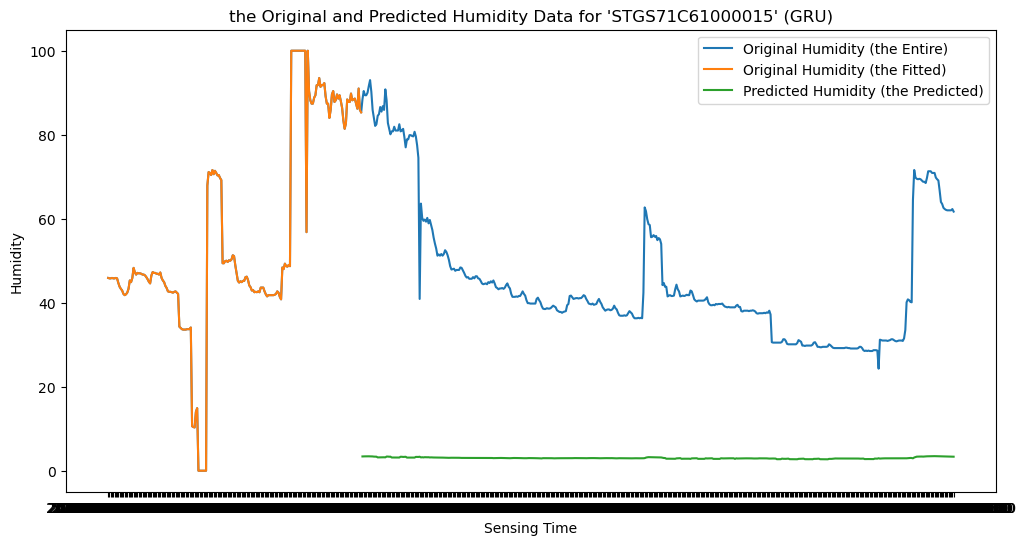

In [24]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000015'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0771
Epoch 2/50
7/7 [==============================] - 0s 834us/step - loss: 0.0376
Epoch 3/50
7/7 [==============================] - 0s 834us/step - loss: 0.0235
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0205
Epoch 6/50
7/7 [==============================] - 0s 833us/step - loss: 0.0176
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0157
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0116
Epoch 11/50
7/7 [==============================] - 0s 834us/step - lo

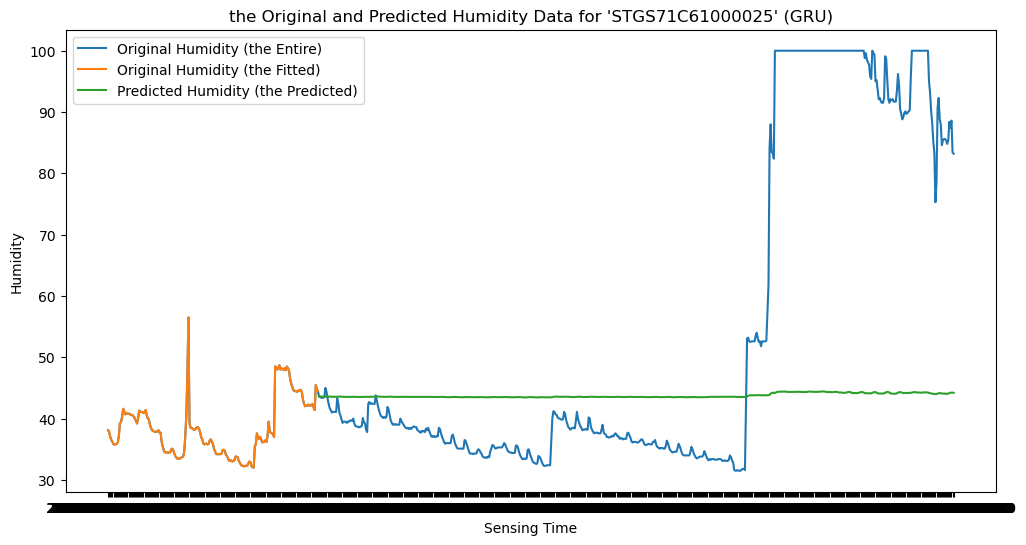

In [25]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000025'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.2036
Epoch 2/50
7/7 [==============================] - 0s 834us/step - loss: 0.1272
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0857
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0632
Epoch 5/50
7/7 [==============================] - 0s 834us/step - loss: 0.0533
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 8/50
7/7 [==============================] - 0s 833us/step - loss: 0.0303
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0202
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.

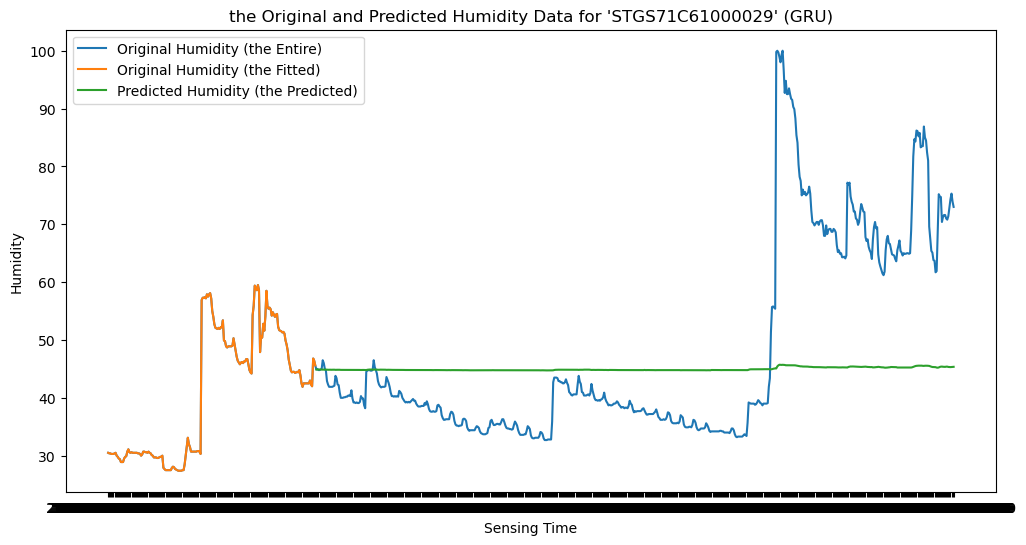

In [26]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000029'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

In [ ]:
# ValueError: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required by MinMaxScaler.
# PASS 38

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
2/2 [==============================] - 1s 2ms/step - loss: 0.3059
Epoch 2/50
2/2 [==============================] - 0s 2ms/step - loss: 0.2665
Epoch 3/50
2/2 [==============================] - 0s 2ms/step - loss: 0.2268
Epoch 4/50
2/2 [==============================] - 0s 1000us/step - loss: 0.1919
Epoch 5/50
2/2 [==============================] - 0s 2ms/step - loss: 0.1565
Epoch 6/50
2/2 [==============================] - 0s 1000us/step - loss: 0.1268
Epoch 7/50
2/2 [==============================] - 0s 2ms/step - loss: 0.1002
Epoch 8/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0757
Epoch 9/50
2/2 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 10/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0401
Epoch 11/50
2/2 [==============================] - 0s 2ms/step - loss: 0.

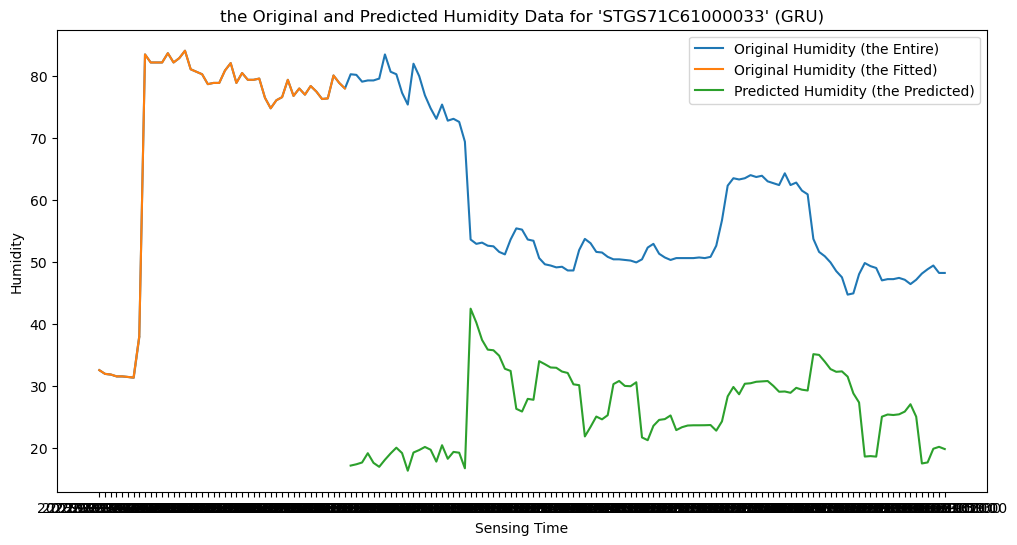

In [30]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000033'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
1/1 [==============================] - 1s 732ms/step - loss: 0.3527
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3304
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3093
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2892
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2701
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2521
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2347
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2181
Epoch 9/50
1/1 [==============================] - 0s 1ms/step - loss: 0.2020
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1868
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1727

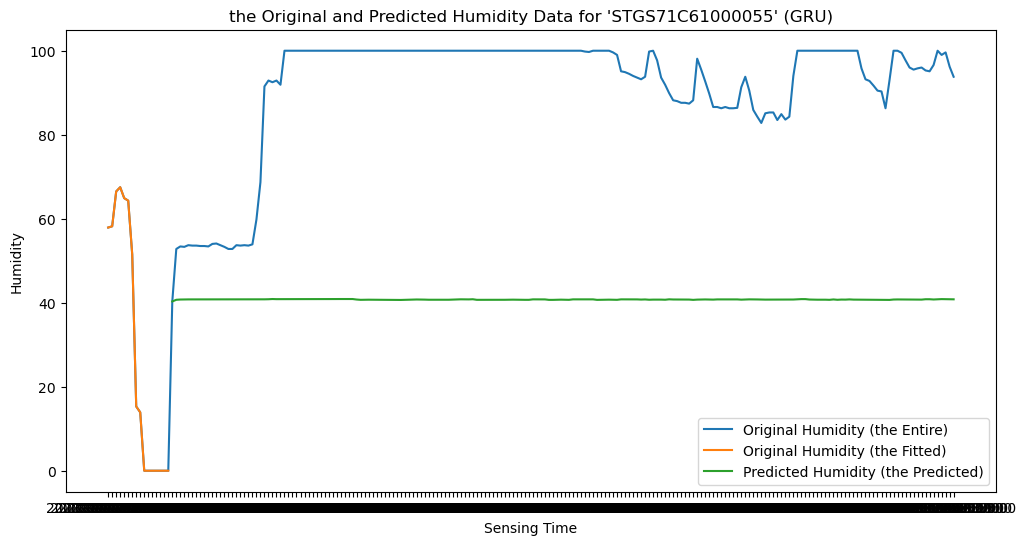

In [31]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000055'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1143
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0608
Epoch 3/50
7/7 [==============================] - 0s 834us/step - loss: 0.0374
Epoch 4/50
7/7 [==============================] - 0s 833us/step - loss: 0.0332
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0297
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 7/50
7/7 [==============================] - 0s 833us/step - loss: 0.0220
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0173
Epoch 11/50
7/7 [==============================] - 0s 834us/step - loss

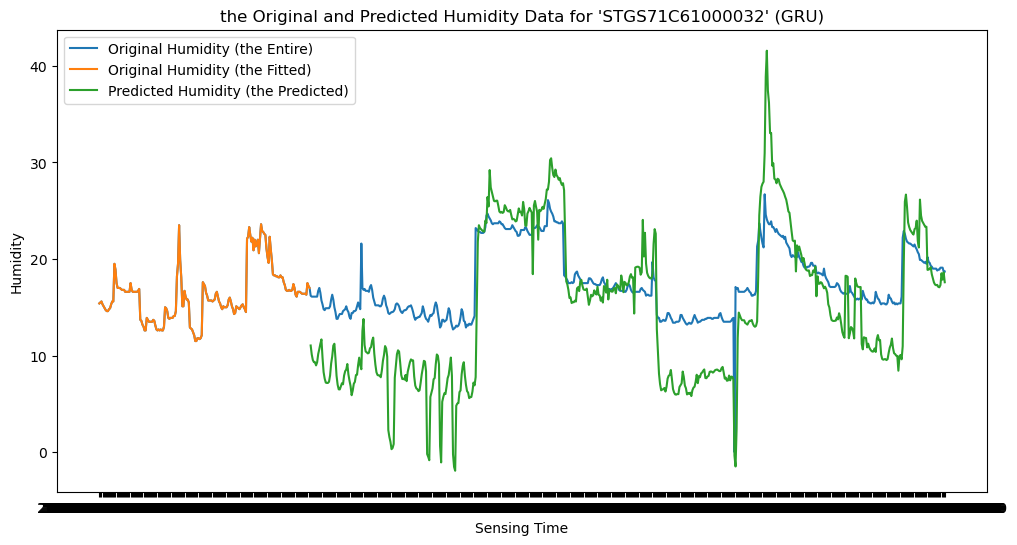

In [32]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000032'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0729
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0319
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 4/50
7/7 [==============================] - 0s 833us/step - loss: 0.0217
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0211
Epoch 6/50
7/7 [==============================] - 0s 834us/step - loss: 0.0188
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0167
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0160
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 

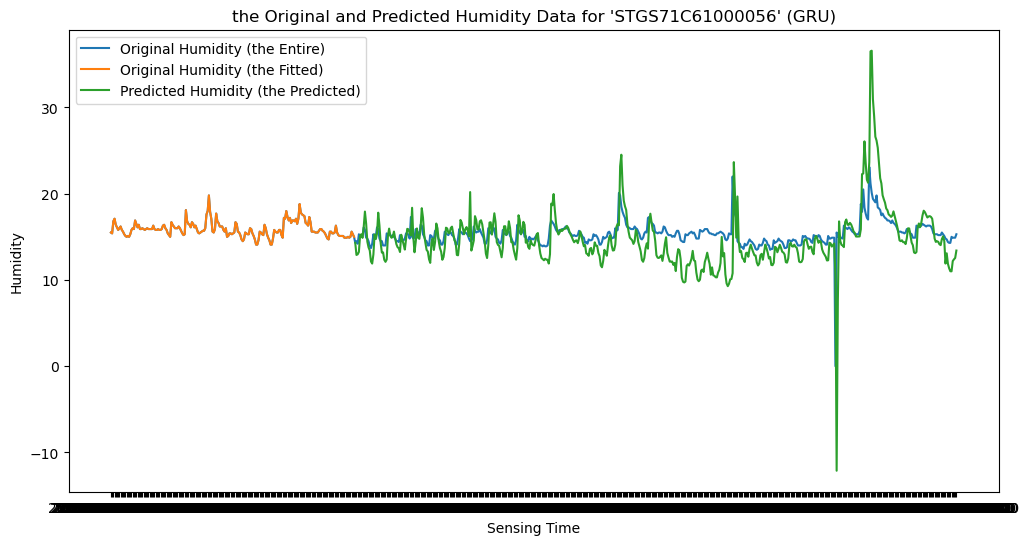

In [66]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000056'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

In [ ]:
'''2023년 9월, 10월, 11월 가지고 하는 테스트는 이것으로 잠정 종료이고...
요 9월~11월 데이터 가지고 2023년 12월이랑 2024년 1월 데이터 맞춰 테스트 해봅시다.
단, 개형보면 알겠지만, 개형이 어느정도 맞는 센서에 한해서 추가 테스트고,
2024년 1월 말까지 살아있는 센서에 한해서 테스트...

즉, 추가 테스트는 좀더 사실에 입각한 테스트...


그외에 개형이 잘 안 맞는 원인 찾아보기...
'''

In [ ]:
'''
개형이 비교적 잘 맞는 센서 리스트 : 
65,47,32,10
56(sh), 06(flower), 13(dream),
17(unreg),18(unreg),22(coffee1),28(coffee2),
# -----------------------------------------------

OK(data exists until 20240129) : 

65(coffee2), 47(coffee2), 32(sports center), 
10(coffee1),28,06,13



'''

In [68]:
sh2.columns

Index(['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime', 'agency', 'site',
       'auto', 'manual', 'anomaly', 'agency_seoul', 'agency2_seong',
       'site_flower', 'site_dgarden', 'site_coffee1', 'site_coffee2',
       'site_rooftop', 'site_spcmplx', 'humi_diff', 'humi_diff_pct',
       'humi_diff_ratio', 'wet_soil', 'normal_soil', 'dry_soil',
       'artificial_soil'],
      dtype='object')

In [69]:
x_cols

['battery',
 'temp',
 'ph_',
 'ec',
 'nitro',
 'phos',
 'pota',
 'k_temp_',
 'k_rain_',
 'sensingTime_',
 'humi_lag_1',
 'humi_lag_2',
 'humi_lag_3',
 'sensingTime']

In [70]:
sh2.sensingTime.unique()

array(['2023-09-14 04:00', '2023-09-14 04:01', '2023-09-14 05:00', ...,
       '2023-11-09 18:33', '2023-11-09 19:13', '2023-11-09 23:16'],
      dtype=object)

In [5]:
sh2_065 = pd.read_csv("C:/Users/Administrator/sensor_data_202401291737_065.csv")

In [6]:
sh2_065.head()

,bat,temp,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime
0,100,3.3,7.49,0.0,0.0,0.0,0.0,NaN,NaN,2024-01-29 17:01:30.000
1,100,4.4,7.40,0.0,0.0,0.0,0.0,4,0,2024-01-29 15:01:55.000
2,100,5.4,7.47,0.0,0.0,0.0,0.0,3,0,2024-01-29 13:00:57.000
3,100,3.0,7.63,0.0,0.0,0.0,0.0,1,0,2024-01-29 11:00:39.000
4,100,-2.1,8.07,0.0,0.0,0.0,0.0,-2,0,2024-01-29 09:01:36.000


In [92]:
sh2_065.dtypes

battery           int64
temp            float64
ph              float64
ec              float64
nitro           float64
phos            float64
pota            float64
k_temp           object
k_rain           object
sensingTime      object
sensingTime_    float64
dtype: object

In [7]:
sh2_065['k_rain'].fillna('-',inplace=True)

In [8]:
sh2_065['k_temp'].fillna('-',inplace=True)

In [9]:
sh2_065.rename(columns = {'bat':'battery'},inplace=True)  

In [4]:
def col_k_dash_remover_(df, col_k):
    if len(df) != 0:
        cnt = 0
        for i in range(len(df)):
            # Num_rows : 1
            if len(df) == 1 and '-' in df[col_k].iloc[i]:
                df[col_k].iloc[i] = 0
            # Num_rows : 2
            if len(df) == 2 and i == 0:
                if '-' in df[col_k].iloc[i] and '-' not in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = df[col_k].iloc[i+1]
                elif '-' not in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:    
                    df[col_k].iloc[i+1] = df[col_k].iloc[i]
                elif '-' in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = 0
                    df[col_k].iloc[i+1] = 0
            # ----------------------------------------------------------------------------------
            # Num_rows > 2
            if len(df) > 2:
                ## initial term
                if i == 0 and '-' in df[col_k].iloc[i]: 
                    # CASE1 : '-' // num
                    if '-' not in df[col_k].iloc[i+1]:
                        #prfloat('CASE1-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i+1]
                    # CASE2 : '-' // '-'
                    elif '-' in df[col_k].iloc[i+1]:
                        #df[col_k].iloc[i] = 0
                        #prfloat('CASE1-2')
                        cnt += 1
                        continue
                ## middle term ---------------------------------------------------------------------------
                elif i > 0 and '-' in df[col_k].iloc[i] and i < len(df) - 1:
                     # CASE1 : ordinary ; prev : num // current : '-' // next : num 
                    if '-' not in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        #prfloat('CASE2-1')
                        df[col_k].iloc[i] = str((float(df[col_k].iloc[i-1]) + float(df[col_k].iloc[i+1]))//2)
                    # CASE2 : '-' // '-' // '-'
                    elif '-' in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #prfloat('CASE2-2')
                        cnt += 1
                        continue
                    # CASE3 : num // '-' // '-'
                    elif '-' not in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #prfloat('CASE2-3')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE4 : '-' // '-' // num
                    elif '-' in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        cnt += 1
                        # sum
                        #prfloat('CASE2-4')
                        for j in range(cnt):
                            #prfloat('i : {}'.format(i))
                            #prfloat('j : {}'.format(j))
                            #prfloat('cnt : {}'.format(cnt))
                            #prfloat('i - cnt + j : {}'.format(i-cnt+j+1))
                            df[col_k].iloc[i-cnt+j+1] = df[col_k].iloc[i+1]
                            #prfloat(df[col_k].iloc[i+1])
                            #prfloat('-'*10)
                            #prfloat(df[col_k].iloc[i-cnt+j+1])
                            #prfloat('-'*20)
                        # -------
                        cnt = 0
                # -------------------------------------------------------------------------------------------
                ## final term
                elif i == len(df) - 1 and '-' in df[col_k].iloc[i]:
                    # CASE1 : num // '-'
                    if '-' not in df[col_k].iloc[i-1]:
                        #prfloat('CASE3-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE2 : '-' // '-' # ex. in the case all data values : '-'
                    elif '-' in df[col_k].iloc[i-1]:
                        #prfloat('CASE3-2')
                        # sum
                        if cnt == len(df) - 1:
                            for j in range(cnt):
                                df[col_k].iloc[j] = 0
                        else:
                            prfloat('CASE3-4')
                            prfloat('case inspection needed ...')

In [10]:
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2_065
lag_num = 3
# -------------------------------------------------------------------------

# the lagged part removed

lagged_df = sh2_065

# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover_(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']

# KeyError: "None of [Index(['humi'], dtype='object')] are in the [columns]"
y_cols = ['humi']


# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11


KeyError: "None of [Index(['humi'], dtype='object')] are in the [columns]"

### Debugging

In [ ]:
"""
sensor_num_input = 'STGS71C61000056'

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[33], line 43
     41 col_lst = ['k_temp','k_rain']
     42 for i in range(len(col_lst)):
---> 43     col_k_dash_remover(lagged_df,col_lst[i])
     44 # ---------------------------------------------------------------------------------------------------------------------
     45 x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
     46        'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']

Cell In[2], line 43, in col_k_dash_remover(df, col_k)
     40 ## middle term ---------------------------------------------------------------------------
     41 elif i > 0 and '-' in df[col_k].iloc[i]:
     42      # CASE1 : ordinary ; prev : num // current : '-' // next : num 
---> 43     if '-' not in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
     44         #print('CASE2-1')
     45         df[col_k].iloc[i] = str((int(df[col_k].iloc[i-1]) + int(df[col_k].iloc[i+1]))//2)
     46     # CASE2 : '-' // '-' // '-'


IndexError: single positional indexer is out-of-bounds

"""

In [38]:
lagged_df.k_temp.unique()

array(['20', '22', '25', '26', '27', '24', '21', '23', '19', '18', '15',
       '16', '17', '14', '13', '12', '11', '10', '9', '8', '7', '5', '6',
       '4', '2', '1', '3', '0', '-'], dtype=object)

In [39]:
lagged_df.k_rain.unique()

array(['0', '1', '2', '-', '5', '10', '3', '4', '8', '7', '24', '6', '11',
       '16'], dtype=object)

In [46]:
lagged_df[lagged_df['k_rain'] == '-']

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,humi_lag_1,humi_lag_2,humi_lag_3,sensingTime_
27869,27870,STGS71C61000056,100,23.5,16.3,5.85,0.08,9,13,33,-,-,2023-09-16 19:00,0,0,15.9,15.9,15.9,202309161900
28106,28107,STGS71C61000056,100,14.8,14.6,6.55,0.06,8,11,29,-,-,2023-10-06 19:00,0,0,14.7,15.1,15.8,202310061900
28183,28184,STGS71C61000056,100,13.6,14.7,6.34,0.09,10,13,34,-,-,2023-10-13 07:00,0,0,14.8,14.7,15.0,202310130700
28352,28353,STGS71C61000056,100,16.4,14.5,6.81,0.10,10,14,36,-,-,2023-10-27 15:54,0,0,17.2,17.6,18.5,202310271554
28379,28380,STGS71C61000056,100,9.3,13.5,6.42,0.10,10,14,36,9,-,2023-10-30 04:00,0,0,14.0,14.1,14.5,202310300400
28380,28381,STGS71C61000056,100,9.1,13.6,6.42,0.10,10,14,36,9,-,2023-10-30 05:00,0,0,13.5,14.0,14.1,202310300500
28381,28382,STGS71C61000056,100,9.0,13.6,6.42,0.10,10,14,36,9,-,2023-10-30 05:30,1,0,13.6,13.5,14.0,202310300530
28433,28434,STGS71C61000056,100,21.9,0.0,6.76,0.00,0,0,0,-,-,2023-11-03 13:46,0,0,14.9,14.9,14.9,202311031346
28437,28438,STGS71C61000056,100,15.8,14.8,6.33,0.10,10,14,36,-,-,2023-11-04 04:00,0,0,15.2,15.0,15.5,202311040400
28454,28455,STGS71C61000056,100,15.2,18.8,6.66,0.10,10,14,36,-,-,2023-11-05 07:00,0,0,15.7,15.3,15.3,202311050700


In [63]:
lagged_df[lagged_df['k_rain'] != '-'][650:]

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,humi_lag_1,humi_lag_2,humi_lag_3,sensingTime_
28484,28485,STGS71C61000056,100,7.0,16.0,7.06,0.1,10,14,36,6,0,2023-11-07 19:00,0,0,16.3,16.5,16.6,202311071900
28485,28486,STGS71C61000056,100,4.7,15.6,7.22,0.1,10,14,36,2,0,2023-11-08 04:00,0,0,16.0,16.3,16.5,202311080400
28486,28487,STGS71C61000056,100,4.5,15.6,7.27,0.1,10,14,36,2,0,2023-11-08 05:00,0,0,15.6,16.0,16.3,202311080500
28487,28488,STGS71C61000056,100,4.5,15.6,7.28,0.1,10,14,36,2,0,2023-11-08 05:30,0,0,15.6,15.6,16.0,202311080530
28488,28489,STGS71C61000056,100,4.5,15.5,7.31,0.1,10,14,36,2,0,2023-11-08 06:00,0,0,15.6,15.6,15.6,202311080600
28489,28490,STGS71C61000056,100,4.4,15.5,7.32,0.1,10,14,36,2,0,2023-11-08 06:30,0,0,15.5,15.6,15.6,202311080630
28490,28491,STGS71C61000056,100,4.4,15.4,7.31,0.1,10,14,36,1,0,2023-11-08 07:00,0,0,15.5,15.5,15.6,202311080700
28491,28492,STGS71C61000056,100,5.6,15.5,7.27,0.1,10,14,36,5,0,2023-11-08 09:00,0,0,15.4,15.5,15.5,202311080900
28492,28493,STGS71C61000056,100,9.7,15.9,7.34,0.1,10,14,36,10,0,2023-11-08 11:00,0,0,15.5,15.4,15.5,202311081100
28493,28494,STGS71C61000056,100,11.2,15.9,7.56,0.1,10,14,36,13,0,2023-11-08 13:00,0,0,15.9,15.5,15.4,202311081300


In [36]:
lagged_df[['k_temp','k_rain']]

,k_temp,k_rain
27834,20,0
27835,20,0
27836,20,0
27837,20,0
27838,20,0
...,...,...
28529,2,0
28530,2,0
28531,1,0
28532,0,0


In [58]:
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------

In [3]:
def col_k_dash_remover_(df, col_k):
    if len(df) != 0:
        cnt = 0
        for i in range(len(df)):
            # Num_rows : 1
            if len(df) == 1 and '-' in df[col_k].iloc[i]:
                df[col_k].iloc[i] = 0
            # Num_rows : 2
            if len(df) == 2 and i == 0:
                if '-' in df[col_k].iloc[i] and '-' not in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = df[col_k].iloc[i+1]
                elif '-' not in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:    
                    df[col_k].iloc[i+1] = df[col_k].iloc[i]
                elif '-' in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = 0
                    df[col_k].iloc[i+1] = 0
            # ----------------------------------------------------------------------------------
            # Num_rows > 2
            if len(df) > 2:
                ## initial term
                if i == 0 and '-' in df[col_k].iloc[i]: 
                    # CASE1 : '-' // num
                    if '-' not in df[col_k].iloc[i+1]:
                        print('CASE1-1')
                        print(i)
                        df[col_k].iloc[i] = df[col_k].iloc[i+1]
                    # CASE2 : '-' // '-'
                    elif '-' in df[col_k].iloc[i+1]:
                        #df[col_k].iloc[i] = 0
                        print('CASE1-2')
                        print(i)
                        cnt += 1
                        continue
                ## middle term ---------------------------------------------------------------------------
                elif i > 0 and '-' in df[col_k].iloc[i] and i < len(df) - 1:
                     # CASE1 : ordinary ; prev : num // current : '-' // next : num 
                    if '-' not in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        print('CASE2-1')
                        print(i)
                        df[col_k].iloc[i] = str((int(df[col_k].iloc[i-1]) + int(df[col_k].iloc[i+1]))//2)
                    # CASE2 : '-' // '-' // '-'
                    elif '-' in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        print('CASE2-2')
                        print(i)
                        cnt += 1
                        continue
                    # CASE3 : num // '-' // '-'
                    elif '-' not in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        print('CASE2-3')
                        print(i)
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE4 : '-' // '-' // num
                    elif '-' in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        cnt += 1
                        # sum
                        print('CASE2-4')
                        print(i)
                        for j in range(cnt):
                            #print('i : {}'.format(i))
                            #print('j : {}'.format(j))
                            #print('cnt : {}'.format(cnt))
                            #print('i - cnt + j : {}'.format(i-cnt+j+1))
                            df[col_k].iloc[i-cnt+j+1] = df[col_k].iloc[i+1]
                            #print(df[col_k].iloc[i+1])
                            #print('-'*10)
                            #print(df[col_k].iloc[i-cnt+j+1])
                            #print('-'*20)
                        # -------
                        cnt = 0
                # -------------------------------------------------------------------------------------------
                ## final term
                elif i == len(df) - 1 and '-' in df[col_k].iloc[i]:
                    # CASE1 : num // '-'
                    if '-' not in df[col_k].iloc[i-1]:
                        print('CASE3-1')
                        print(i)
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE2 : '-' // '-' # ex. in the case all data values : '-'
                    elif '-' in df[col_k].iloc[i-1]:
                        print('CASE3-2')
                        print(i)
                        # sum
                        if cnt == len(df) - 1:
                            for j in range(cnt):
                                df[col_k].iloc[j] = 0
                        else:
                            print('CASE3-4')
                            print(i)
                            print('case inspection needed ...')

In [51]:
len(lagged_df)

700

In [55]:
lagged_df

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,humi_lag_1,humi_lag_2,humi_lag_3,sensingTime_
27834,27835,STGS71C61000056,100,20.3,15.5,5.48,0.06,8,11,29,20,0,2023-09-14 04:00,0,0,15.5,15.5,15.5,202309140400
27835,27836,STGS71C61000056,100,20.0,15.4,5.54,0.06,8,11,29,20,0,2023-09-14 05:00,0,0,15.5,15.5,15.5,202309140500
27836,27837,STGS71C61000056,100,20.1,16.8,5.56,0.08,9,12,32,20,0,2023-09-14 05:30,0,0,15.4,15.5,15.5,202309140530
27837,27838,STGS71C61000056,100,20.0,17.1,5.61,0.10,10,14,36,20,0,2023-09-14 06:01,0,0,16.8,15.4,15.5,202309140601
27838,27839,STGS71C61000056,100,19.7,16.4,5.72,0.10,10,14,36,20,0,2023-09-14 06:30,0,0,17.1,16.8,15.4,202309140630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28529,28530,STGS71C61000056,100,1.8,15.0,7.51,0.10,10,14,36,2,0,2023-11-11 06:00,0,0,14.3,14.3,14.4,202311110600
28530,28531,STGS71C61000056,100,1.5,14.9,7.5,0.10,10,14,36,2,0,2023-11-11 06:30,0,0,15.0,14.3,14.3,202311110630
28531,28532,STGS71C61000056,100,1.4,14.9,7.49,0.10,10,14,36,1,0,2023-11-11 07:00,0,0,14.9,15.0,14.3,202311110700
28532,28533,STGS71C61000056,100,2.5,14.9,7.44,0.10,10,14,36,0,0,2023-11-11 09:00,0,0,14.9,14.9,15.0,202311110900


In [60]:
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover_(lagged_df,col_lst[i])

CASE2-1
35
CASE2-1
272
CASE2-1
349
CASE2-1
518
CASE2-1
599
CASE2-1
603
CASE2-1
620
CASE2-1
654
CASE2-3
673
CASE2-3
674
CASE2-3
675
CASE2-3
676
CASE2-3
677
CASE2-3
678
CASE2-1
679
CASE2-3
692
CASE2-3
693
CASE2-3
694
CASE2-3
695
CASE2-3
696
CASE2-1
697
CASE3-1
699
CASE2-1
35
CASE2-1
272
CASE2-1
349
CASE2-1
518
CASE2-3
545
CASE2-3
546
CASE2-1
547
CASE2-1
599
CASE2-1
603
CASE2-1
620
CASE2-1
654
CASE2-3
673
CASE2-3
674
CASE2-3
675
CASE2-3
676
CASE2-3
677
CASE2-3
678
CASE2-1
679
CASE3-1
699
